In [68]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import Bounds, BFGS
from scipy.optimize import LinearConstraint, minimize
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

noise = 16
seed = 244823
samples = 2423
loop = 100
zero = 1e-7

def linear_kernel(x1, x2, *args):
    return np.dot(x1, x2)

def decision_function(x, w, b, linear, support_param=None, alpha_param=None, train_labels2=None, train_vector=None, kernel=None, degree=None, gamma=None):
    if linear:
        return np.dot(x, w) + b
    else:
        y_pred = []
        for sample in x:
            pred = 0
            for i in support_param:
                pred += alpha_param[i] * train_labels2[i] * kernel(sample, train_vector[i, :], degree, gamma, b)
            y_pred.append(pred)

        return np.array(y_pred)

def lagrange_function(alpha, x, y2, kernel, degree, gamma):
    res = 0
    for i in range(alpha.shape[0]):
        for j in range(alpha.shape[0]):
            res += alpha[i] * alpha[j] * y2[i] * y2[j] * kernel(x[i], x[j], degree, gamma, 0)

    return  0.5 * res - sum(alpha)

def fit(x_train, y_train2, kernel, degree=1, gamma=0.1, C=1.0):
    ZERO = 1e-5

    n, m = x_train.shape
    alpha_start = np.random.uniform(0, C, size=n)
    linear_constraint = LinearConstraint(A=y_train2, lb=[0], ub=[0])
    bounds = Bounds(np.zeros(n), np.full(n, C-ZERO))
    result = minimize(
        fun=lagrange_function,
        x0=alpha_start,
        args=(x_train, y_train2, kernel, degree, gamma),
        constraints=[linear_constraint],
        bounds=bounds)
    alpha_ = result.x
    alpha_[alpha_ < ZERO] = 0
    support_ = np.where(alpha_ > ZERO)[0]
    support_vectors_ = x_train[support_]
    support_labels = y_train2[support_]
    train_vectors_ = x_train
    train_labels = y_train2

    coef_ = np.zeros(m)
    for i in support_:
        coef_ += alpha_[i] * y_train2[i] * x_train[i]

    intercept_ = 0
    for i in support_:
        intercept_ += y_train2[i] - np.dot(coef_, x_train[i])
    intercept_ /= len(support_)
    return coef_, intercept_, support_vectors_, support_, alpha_, train_labels, train_vectors_

def predict(x, w, b, linear, support_param=None, alpha_param=None, train_labels=None, train_vector=None, kernel=None, degree=None, gamma=None):
    return np.sign(decision_function(x, w, b, linear, support_param, alpha_param, train_labels, train_vector, kernel, degree, gamma))

<h3 align="center"><font size="10">Część 1 - make classification</font></h3>

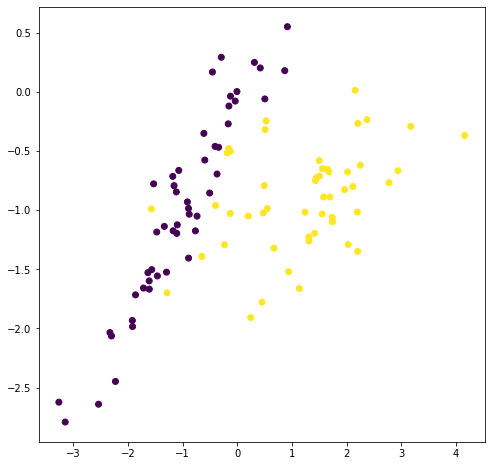

In [69]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=100, test_size=0.5, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain)
plt.show()

In [70]:
theta, bias, support_v, support, alpha, train_label, train_vectors = fit(xtrain, ytrain, kernel=linear_kernel, degree=1, gamma=0.1, C=1.0)

In [71]:
predict_var = predict(xtest, theta, bias, linear=True)

Czułość modelu własnego SVM dla datasetu make classification wynosi: 0.9207
Specyficzność modelu własnego SVM dla datasetu make classification wynosi: 0.883


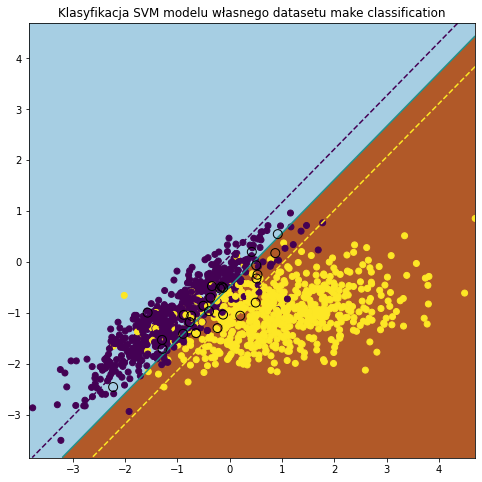

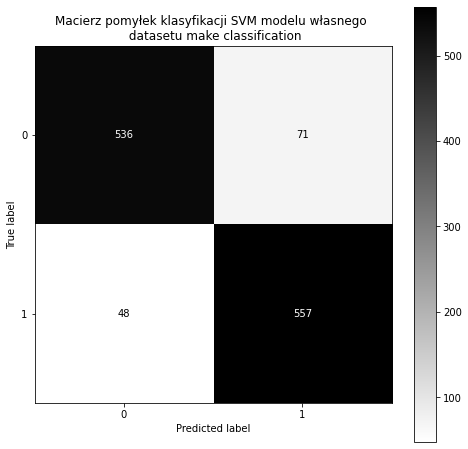

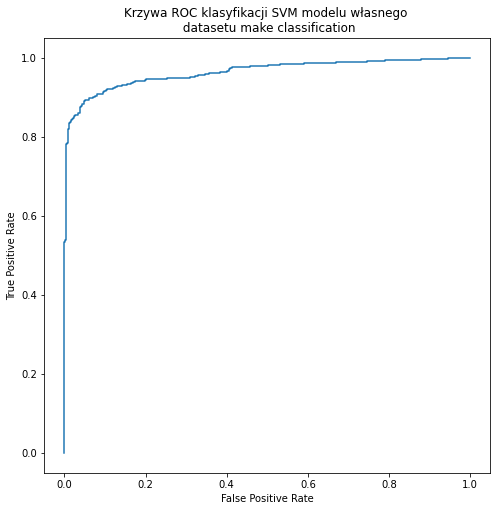

In [72]:
mesh_data = np.c_[xx.ravel(), yy.ravel()]

predict_cntr = predict(mesh_data, theta, bias, True)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, True).reshape(xx.shape)

plt.title('Klasyfikacja SVM modelu własnego datasetu make classification')
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(xtest[:, 0], xtest[:, 1], c=ytest)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')


cm_model = confusion_matrix(ytest, predict_var, labels=[-1, 1])
tn, fp, fn, tp = confusion_matrix(ytest, predict_var).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print(f'Czułość modelu własnego SVM dla datasetu make classification wynosi: {round(sensitivity, 4)}')
print(f'Specyficzność modelu własnego SVM dla datasetu make classification wynosi: {round(specificity, 4)}')
ConfusionMatrixDisplay(cm_model).plot(cmap='binary')

fpr, tpr, roc_auc = roc_curve(ytest, decision_function(xtest, theta, bias, True))

plt.title('Macierz pomyłek klasyfikacji SVM modelu własnego \n datasetu make classification')
roc_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_model.plot()
plt.title('Krzywa ROC klasyfikacji SVM modelu własnego \n datasetu make classification')
plt.show()

Czułość modelu sklearn SVM dla datasetu make classification wynosi: 0.9207
Specyficzność modelu sklearn SVM dla datasetu make classification wynosi: 0.883


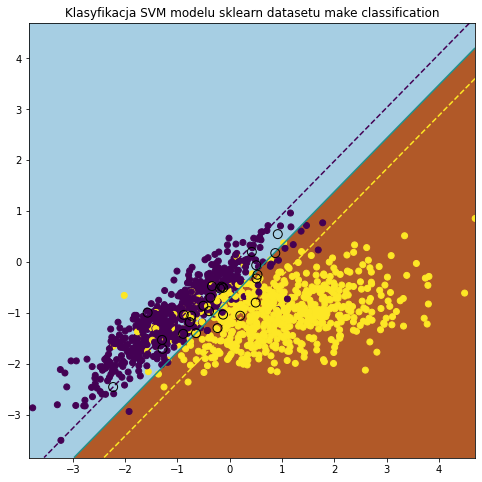

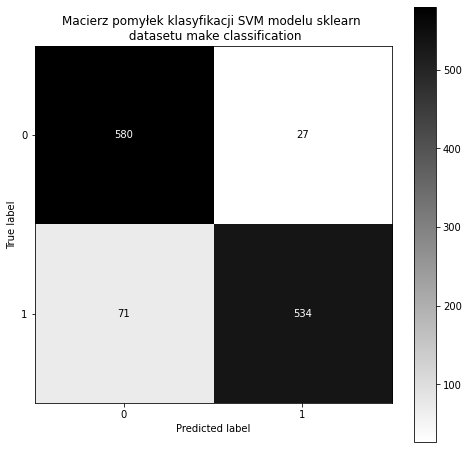

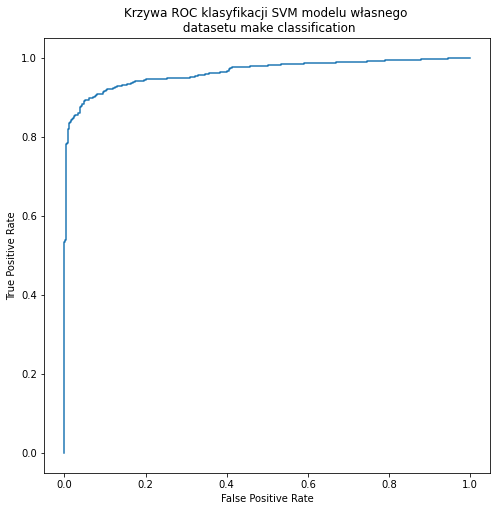

In [73]:
from sklearn.svm import SVC

model = SVC(kernel='linear', gamma=0.1, degree=1, random_state=seed, C=1)
model.fit(xtrain, ytrain)
prd = model.predict(xtest)
mesh_data = np.c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.title('Klasyfikacja SVM modelu sklearn datasetu make classification')
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(xtest[:, 0], xtest[:, 1], c=ytest)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(ytest, prd, labels=[-1, 1])
tn, fp, fn, tp = confusion_matrix(ytest, predict_var).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print(f'Czułość modelu sklearn SVM dla datasetu make classification wynosi: {round(sensitivity,4)}')
print(f'Specyficzność modelu sklearn SVM dla datasetu make classification wynosi: {round(specificity,4)}')
ConfusionMatrixDisplay(cm_model).plot(cmap='binary')

fpr, tpr, roc_auc = roc_curve(ytest, model.decision_function(xtest))

plt.title('Macierz pomyłek klasyfikacji SVM modelu sklearn \n datasetu make classification')
rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()
plt.title('Krzywa ROC klasyfikacji SVM modelu własnego \n datasetu make classification')
plt.show()

<h3 align="center"><font size="10">Część 1 - make moons</font></h3>

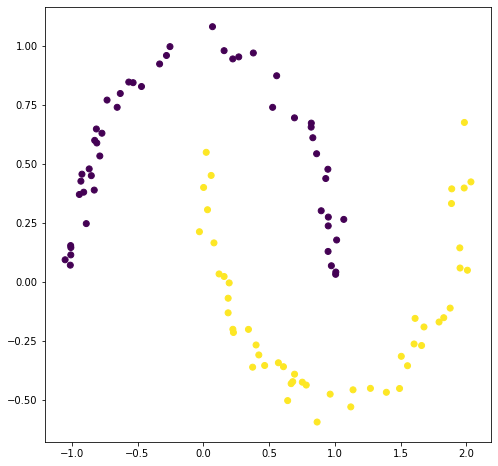

In [74]:
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=100, test_size=0.5, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain)
plt.show()

In [75]:
theta, bias, support_v, support, alpha, train_label, train_vectors = fit(xtrain, ytrain, kernel=linear_kernel, degree=1, gamma=0.1, C=1.0)
predict_var = predict(xtest, theta, bias, linear=True)

Czułość modelu własnego SVM dla datasetu make moons wynosi: 0.863
Specyficzność modelu własnego SVM dla datasetu make moons wynosi: 0.8944


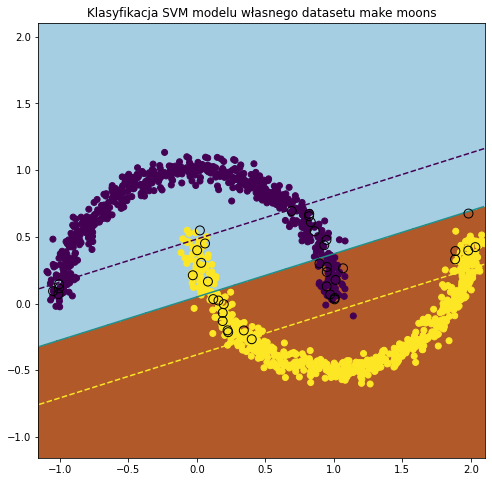

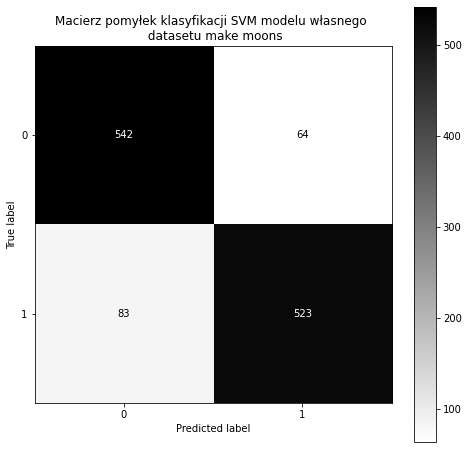

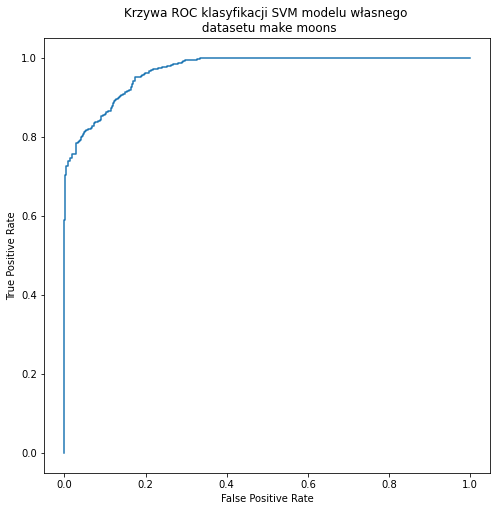

In [76]:
mesh_data = np.c_[xx.ravel(), yy.ravel()]

predict_cntr = predict(mesh_data, theta, bias, True)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, True).reshape(xx.shape)

plt.title('Klasyfikacja SVM modelu własnego datasetu make moons')
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(xtest[:, 0], xtest[:, 1], c=ytest)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(ytest, predict_var, labels=[-1, 1])
tn, fp, fn, tp = confusion_matrix(ytest, predict_var).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print(f'Czułość modelu własnego SVM dla datasetu make moons wynosi: {round(sensitivity,4)}')
print(f'Specyficzność modelu własnego SVM dla datasetu make moons wynosi: {round(specificity,4)}')
ConfusionMatrixDisplay(cm_model).plot(cmap='binary')

fpr, tpr, roc_auc = roc_curve(ytest, decision_function(xtest, theta, bias, True))

plt.title('Macierz pomyłek klasyfikacji SVM modelu własnego \n datasetu make moons')
roc_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_model.plot()
plt.title('Krzywa ROC klasyfikacji SVM modelu własnego \n datasetu make moons')
plt.show()

Czułość modelu sklearn SVM dla datasetu make moons wynosi: 0.863
Specyficzność modelu sklearn SVM dla datasetu make moons wynosi: 0.8944


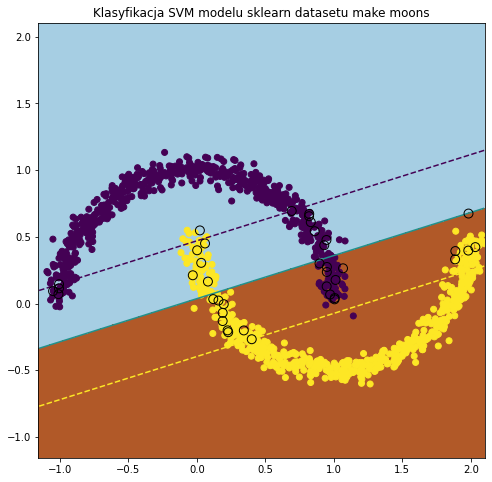

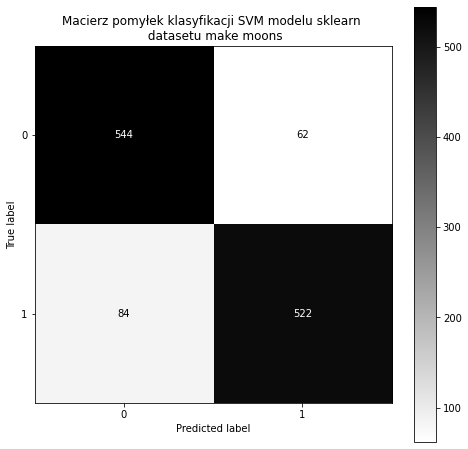

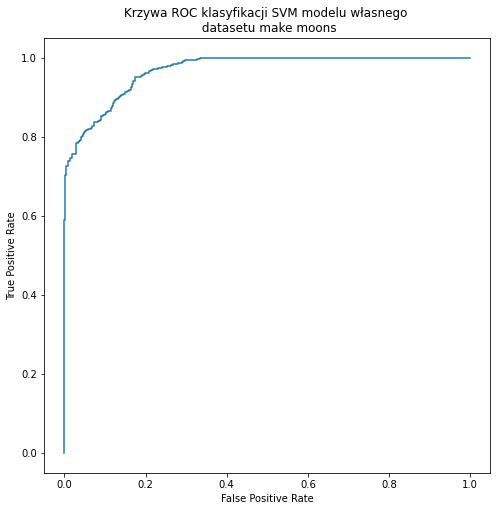

In [77]:
model = SVC(kernel='linear', gamma=0.1, degree=1, random_state=seed, C=1)
model.fit(xtrain, ytrain)
prd = model.predict(xtest)
mesh_data = np.c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.title('Klasyfikacja SVM modelu sklearn datasetu make moons')
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(xtest[:, 0], xtest[:, 1], c=ytest)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(ytest, prd, labels=[-1, 1])
tn, fp, fn, tp = confusion_matrix(ytest, predict_var).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

print(f'Czułość modelu sklearn SVM dla datasetu make moons wynosi: {round(sensitivity,4)}')
print(f'Specyficzność modelu sklearn SVM dla datasetu make moons wynosi: {round(specificity,4)}')
ConfusionMatrixDisplay(cm_model).plot(cmap='binary')

fpr, tpr, roc_auc = roc_curve(ytest, model.decision_function(xtest))

plt.title('Macierz pomyłek klasyfikacji SVM modelu sklearn \n datasetu make moons')
rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()
plt.title('Krzywa ROC klasyfikacji SVM modelu własnego \n datasetu make moons')
plt.show()